<a href="https://colab.research.google.com/github/tatsuhiko-ikeda3/GAN_with_VIT/blob/main/vit_withse_reduction2_50epoch_flower_D_v_G_sa_FID_KID_devide_1_color_relativistic1_hinge.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#パッケージのダウンロード


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import argparse

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim

In [5]:
import torchvision.transforms as transforms

In [6]:
import torchvision.datasets as dset

In [7]:
import torchvision.utils as vutils

In [8]:
import matplotlib.pyplot as plt
import numpy as np
import tqdm

In [9]:
import glob

In [10]:
from torch.utils.data import Dataset
from PIL import Image

In [11]:
from torch.utils.data import DataLoader
import torchvision

In [12]:
!pip install torchmetrics
!pip install torchmetrics[image]

!pip install torch-fidelity

from torchmetrics.image.inception import InceptionScore


import torchmetrics
import torch_fidelity

import torch
_ = torch.manual_seed(123)
from torchmetrics.image.fid import FrechetInceptionDistance
fid = FrechetInceptionDistance(feature=2048)

from torchmetrics.image.kid import KernelInceptionDistance


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 529 kB 15.7 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 53 kB 2.9 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Downloading: "https://github.com/toshas/torch-fidelity/releases/download/v0.2.0/weights-inception-2015-12-05-6726825d.pth" to /root/.cache/torch/hub/checkpoints/weights-inception-2015-12-05-6726825d.pth


  0%|          | 0.00/91.2M [00:00<?, ?B/s]

In [13]:
kid = KernelInceptionDistance(subset_size=6)

/usr/local/lib/python3.7/dist-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `Kernel Inception Distance` will save all extracted features in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)


In [14]:
#ハイパーパラメータの設定

In [15]:
parser = argparse.ArgumentParser()
parser.add_argument("--n_epoch", type = int, default=50)
parser.add_argument("--batch_size", type = int, default=32)#32
parser.add_argument("--lr_g", type = float, default=2e-4)
parser.add_argument("--lr_d", type = float, default=3e-4)
parser.add_argument("--nch_g", type = int, default=64)#64
parser.add_argument("--nch_d", type = int, default=64)#64
parser.add_argument("--z_dim", type = int, default=100)
parser.add_argument("--beta1", type = float, default=0.5)

opt = parser.parse_args(args=[])
print(opt)

Namespace(batch_size=32, beta1=0.5, lr_d=0.0003, lr_g=0.0002, n_epoch=50, nch_d=64, nch_g=64, z_dim=100)


In [16]:
class ImageDataset(Dataset):
    def __init__(self,  transform = None):
        super().__init__()
        self.file_list = glob.glob("/content/drive/MyDrive/102flowers (2)/jpg/*.jpg")#/content/drive/MyDrive/img_align_celeba.zip
        #self.file_list = glob.glob("/content/drive/MyDrive/cityscapes/cityscapes_data/train/*.jpg" )#/content/drive/MyDrive/cityscapes/cityscapes_data/train
       # self.file_list = glob.glob("/content/drive/MyDrive/Test/Apple**/*.jpg" )#fruits
       # self.file_list = glob.glob("/content/drive/MyDrive/img_align_celeba.zip/jpg/*.jpg")#C:\Users\ikeda\Downloads\img_align_celeba\img_align_celeba
        #self.file_list = glob.glob("/content/drive/MyDrive/–¢Šm”F 758452(1).crdownload/*.jpg")
        self.transform = transform

    
    def __getitem__(self, index):
        if self.transform is not None:
            img = self.transform(Image.open(self.file_list[index]))
        else:
            img = Image.open(self.file_list[index])
        return img
    
    def __len__(self):
        return len(self.file_list)

In [17]:
from torchvision.transforms.transforms import CenterCrop

transform = transforms.Compose([
    
    transforms.Resize(80),
    transforms.CenterCrop(64),
    transforms.ToTensor(), 
                               transforms.Normalize((0.5,),(0.5,))])

In [18]:
#dataset = dset.MNIST("./", train = True, download = True,transform = transform)
dataset = ImageDataset(transform = transform)
#dataset = torchvision.datasets.CelebA("./", split = "test", download = True,transform = transform) #Cityscapes
#dataset = torchvision.datasets.Cityscapes("C:\Users\ikeda\Downloads\cityscapes\cityscapes_data\cityscapes_data", split='train', mode='fine', target_type='color')


In [19]:
dataloader = DataLoader(dataset = dataset, batch_size = opt.batch_size,num_workers = 2,  shuffle = True)

In [20]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find("BatchNorm") != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)
        

In [21]:
#モデルの設定

In [22]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        out_channels = in_channels
        self.conv1 = nn.utils.spectral_norm(nn.Conv2d(in_channels, out_channels,kernel_size = 3, padding = 1))
        self.conv2 = nn.utils.spectral_norm(nn.Conv2d(out_channels, out_channels,kernel_size = 3, padding = 1))
        self.conv3 = nn.utils.spectral_norm(nn.Conv2d(in_channels, out_channels,kernel_size = 1, padding = 0))#kernel_size -> チャネル数だけ変化させること
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()
        self.se_block_0 = SE(out_channels)
    def shortcut(self, x):
        x = self.conv3(x)
        x = self.bn(x)
        return x
        
    def forward(self, x):
        identity = x#入力
        x = self.conv1(x)
        x = self.se_block_0(x)
        x = self.bn(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.se_block_0(x)
        x = self.bn(x)
        x = x + self.shortcut(identity)
        return x   

In [23]:
class ResidualBlock_G(nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        out_channels = in_channels
        self.conv1 = nn.utils.spectral_norm(nn.ConvTranspose2d(in_channels, out_channels,kernel_size = 3, padding = 1))
        self.conv2 = nn.utils.spectral_norm(nn.ConvTranspose2d(out_channels, out_channels,kernel_size = 3, padding = 1))
        self.conv3 = nn.utils.spectral_norm(nn.ConvTranspose2d(in_channels, out_channels,kernel_size = 1, padding = 0))#kernel_size -> チャネル数だけ変化させること
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()
        self.se_block_0 = SE_G(out_channels)
    def shortcut(self, x):
        x = self.conv3(x)
        x = self.bn(x)
        return x
        
    def forward(self, x):
        identity = x#入力
        x = self.conv1(x)
        x = self.se_block_0(x)
        x = self.bn(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.se_block_0(x)
        x = self.bn(x)
        x = x + self.shortcut(identity)
        return x   

In [24]:
class ResidualBlock_1(nn.Module):#実質パディングとスペクトラム正規化とインスタンス正規化
  def __init__(self, in_channels):
    super().__init__()
    self.conv_layers = nn.Sequential(
        nn.ReflectionPad2d(1),
        nn.utils.spectral_norm(nn.Conv2d(in_channels, in_channels, 3)),
        nn.InstanceNorm2d(in_channels),
        nn.ReLU(inplace = True),
        
        nn.ReflectionPad2d(1),
        nn.utils.spectral_norm(nn.Conv2d(in_channels, in_channels, 3)),
        nn.InstanceNorm2d(in_channels),
        
    )
  def forward(self, x):
    out = self.conv_layers(x)
    out = out + x
    return out

In [25]:
class SelfAttention(nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        n_divide = in_channels
        #out_channels = in_channels // n_divide
        out_channels = 1

        self.fx_1x1 = (nn.Conv2d(in_channels, out_channels, kernel_size = 1))#nn.utils.spectral_norm
        self.gx_1x1 = (nn.Conv2d(in_channels, out_channels, kernel_size = 1))#
        self.hx_1x1 = (nn.Conv2d(in_channels, in_channels, kernel_size = 1))#
        self.gamma = nn.Parameter(torch.zeros(1))
        self.softmax = nn.Softmax(dim = -2)#規格化するため -2 
     

    def forward(self, x):
        B, C, H, W = x.size()
        #x = nn.LayerNorm([C,H,W])#input.size()[1:]
        fx = self.fx_1x1(x).view(B, -1, H*W).permute(0,2,1)
        gx = self.gx_1x1(x).view(B, -1, H*W)
        hx = self.hx_1x1(x).view(B, -1, H*W)
        
        s_mtx = torch.bmm(fx, gx)
        attention = self.softmax(s_mtx)
        
        o =torch.bmm(hx, attention)
        o = o.view(B, -1, H, W)
        out = x + self.gamma * o
        return out

In [26]:
#import torch
#from layers.transformer.ScaledDotProductAttention import ScaledDotProductAttention
#from torch import nn


class MultiHeadAttention(nn.Module):
    def __init__(self, in_channels, h = 8):
        super().__init__()  
        d_model = in_channels
        self.d_model = in_channels
        self.h = in_channels
        self.d_k = d_model // h
        self.d_v = d_model // h
        self.fx_1x1 = (nn.Conv2d(in_channels, in_channels//self.h, kernel_size = 1))
        self.gx_1x1 = (nn.Conv2d(in_channels, in_channels//self.h, kernel_size = 1))
        self.hx_1x1 = nn.utils.spectral_norm(nn.Conv2d(in_channels, in_channels, kernel_size = 1))
        self.qkv = nn.utils.spectral_norm(nn.Conv2d(in_channels, 3 * in_channels, kernel_size = 1))

#        self.scaled_dot_product_attention = SelfAttention(self.d_model)

        self.linear = nn.Linear(self.h * self.d_v, d_model)
       # self.fx_1x1 = (nn.Conv2d(in_channels, out_channels, kernel_size = 1))#nn.utils.spectral_norm
        #self.gx_1x1 = (nn.Conv2d(in_channels, out_channels, kernel_size = 1))#
        #self.hx_1x1 = (nn.Conv2d(in_channels, in_channels, kernel_size = 1))#
        self.gamma = nn.Parameter(torch.zeros(1))
        self.softmax = nn.Softmax(dim = -2)#規格化するため -2 

        self.se_block_0 = SE(in_channels)
        self.relu = nn.ReLU()
        
    def forward(self, x ) -> torch.Tensor:
        B, C, H, W = x.size()
        qkv = self.qkv(x)
        self.q, self.k, self.v = qkv.chunk(3, dim = 1)

        #self.q = self.se_block_0(self.q)
        #self.k = self.se_block_0(self.k)
        #self.v = self.se_block_0(self.v)

        """Scaled dot product attention"""
       # attention_output = self.scaled_dot_product_attention(self.q, self.k, self.v)  # (head*batch_size, seq_len, d_model)
        B, C, H, W = self.q.size()
        #x = nn.LayerNorm([C,H,W])#input.size()[1:]
        fx = self.fx_1x1(self.q).view(B, -1, H*W).permute(0,2,1)
        gx = self.gx_1x1(self.k).view(B, -1, H*W)
        hx = self.hx_1x1(self.v).view(B, -1, H*W)
       # fx = self.q.view(B, -1, H*W).permute(0,2,1)
       # gx = self.k.view(B, -1, H*W)
       # hx = self.v.view(B, -1, H*W)
        
        s_mtx = torch.bmm(fx, gx)
        attention = self.softmax(s_mtx)
        
        o =torch.bmm(hx, attention)
        o = o.view(B, -1, H, W)
        out = x + self.gamma * o

        #out = out.repeat(1,self.h*1,1,1)

        #out = torch.chunk(out, self.h, dim=1)
       # out = torch.cat(out, dim=1)

        """Linear after scaled dot product attention"""
        #output = self.linear(out)
        return out


In [27]:

class MultiHeadAttention_G(nn.Module):
    def __init__(self, in_channels, h = 8):
        super().__init__()  
        d_model = in_channels
        self.d_model = in_channels
        self.h = in_channels
        self.d_k = d_model // h
        self.d_v = d_model // h
        self.fx_1x1 = (nn.ConvTranspose2d(in_channels, in_channels//self.h, kernel_size = 1))
        self.gx_1x1 = (nn.ConvTranspose2d(in_channels, in_channels//self.h, kernel_size = 1))
        self.hx_1x1 = nn.utils.spectral_norm(nn.ConvTranspose2d(in_channels, in_channels, kernel_size = 1))
        self.qkv = nn.utils.spectral_norm(nn.ConvTranspose2d(in_channels, 3 * in_channels, kernel_size = 1))

#        self.scaled_dot_product_attention = SelfAttention(self.d_model)

        self.linear = nn.Linear(self.h * self.d_v, d_model)
       # self.fx_1x1 = (nn.Conv2d(in_channels, out_channels, kernel_size = 1))#nn.utils.spectral_norm
        #self.gx_1x1 = (nn.Conv2d(in_channels, out_channels, kernel_size = 1))#
        #self.hx_1x1 = (nn.Conv2d(in_channels, in_channels, kernel_size = 1))#
        self.gamma = nn.Parameter(torch.zeros(1))
        self.softmax = nn.Softmax(dim = -2)#規格化するため -2 

        self.se_block_0 = SE_G(in_channels)
        self.relu = nn.ReLU()
        
    def forward(self, x ) -> torch.Tensor:
        B, C, H, W = x.size()
        qkv = self.qkv(x)
        qkv = self.relu(qkv)
        self.q, self.k, self.v = qkv.chunk(3, dim = 1)

        #self.q = self.se_block_0(self.q)
        #self.k = self.se_block_0(self.k)
        #self.v = self.se_block_0(self.v)
        """Scaled dot product attention"""
       # attention_output = self.scaled_dot_product_attention(self.q, self.k, self.v)  # (head*batch_size, seq_len, d_model)
        B, C, H, W = self.q.size()
        #x = nn.LayerNorm([C,H,W])#input.size()[1:]
        fx = self.fx_1x1(self.q).view(B, -1, H*W).permute(0,2,1)
        gx = self.gx_1x1(self.k).view(B, -1, H*W)
        hx = self.hx_1x1(self.v).view(B, -1, H*W)
       # fx = self.q.view(B, -1, H*W).permute(0,2,1)
       # gx = self.k.view(B, -1, H*W)
       # hx = self.v.view(B, -1, H*W)
        
        s_mtx = torch.bmm(fx, gx)
        attention = self.softmax(s_mtx)
        
        o =torch.bmm(hx, attention)
        o = o.view(B, -1, H, W)
        out = x + self.gamma * o

        #out = out.repeat(1,self.h*1,1,1)

        #out = torch.chunk(out, self.h, dim=1)
       # out = torch.cat(out, dim=1)

        """Linear after scaled dot product attention"""
        #output = self.linear(out)
        return out

In [28]:
class SelfAttention_G(nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        n_divide = in_channels
        out_channels = in_channels // n_divide
      #  out_channels = 1

        self.fx_1x1 = nn.utils.spectral_norm(nn.ConvTranspose2d(in_channels, out_channels, kernel_size = 1))
        self.gx_1x1 = nn.utils.spectral_norm(nn.ConvTranspose2d(in_channels, out_channels, kernel_size = 1))
        self.hx_1x1 = nn.utils.spectral_norm(nn.ConvTranspose2d(in_channels, in_channels, kernel_size = 1))
        self.gamma = nn.Parameter(torch.zeros(1))
        self.softmax = nn.Softmax(dim = -2)#規格化するため -2 
     

    def forward(self, x):
        B, C, H, W = x.size()
        fx = self.fx_1x1(x).view(B, -1, H*W).permute(0,2,1)
        gx = self.gx_1x1(x).view(B, -1, H*W)
        hx = self.hx_1x1(x).view(B, -1, H*W)
        
        s_mtx = torch.bmm(fx, gx)
        attention = self.softmax(s_mtx)
        
        o =torch.bmm(hx, attention)
        o = o.view(B, -1, H, W)
        out = x + self.gamma * o
        return out

In [29]:
class PF(nn.Module):#poolformer
    def __init__(self, in_channels , out_channels):
        super().__init__()
        self.conv1 = nn.utils.spectral_norm(nn.Conv2d(in_channels, out_channels,kernel_size=3, padding=1))#kernel_size=4, stride=2, padding=1
        self.conv2 = nn.utils.spectral_norm(nn.Conv2d(out_channels, out_channels,kernel_size = 3, padding = 1))
        self.conv3 = nn.utils.spectral_norm(nn.Conv2d(in_channels, out_channels,kernel_size = 1, padding = 0))#kernel_size -> チャネル数だけ変化させること
        self.pre_bn = nn.BatchNorm2d(in_channels) 
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()
        self.pool = nn.AvgPool2d(kernel_size = 3, stride = 1, padding = 3//2, count_include_pad=False)
        self.flat = nn.Flatten()
    def shortcut(self, x):
        x = self.conv3(x)
        x = self.bn(x)
        return x
        
    def forward(self, x):
        identity = x#入力
        x = self.pre_bn(x)
        x = self.pool(x) -x
        x = x + identity

        identity = x#入力
        x = self.pre_bn(x)
        x= self.flat(x)
        x = self.conv1(x) 
        x = self.relu(x)
        x = x + self.shortcut(identity)
        return x 

In [30]:
"""    def __init__(self, in_channels):
        super().__init__()
        n_divide = 8
        out_channels = in_channels // n_divide
        self.dim = 3

        self.fx_1x1 = (nn.Conv2d(in_channels, out_channels, kernel_size = 1))#nn.utils.spectral_norm
        self.gx_1x1 = (nn.Conv2d(in_channels, out_channels, kernel_size = 1))#
        self.hx_1x1 = (nn.Conv2d(in_channels, in_channels, kernel_size = 1))#
        self.gamma = nn.Parameter(torch.zeros(1))
        self.softmax = nn.Softmax(dim = -2)#規格化するため -2 
        self.conv1 = nn.utils.spectral_norm(nn.Conv2d(in_channels, out_channels,kernel_size=3, padding=1))#kernel_size=4, stride=2, padding=1
        self.conv2 = nn.utils.spectral_norm(nn.Conv2d(out_channels, out_channels,kernel_size = 3, padding = 1))
        self.conv3 = nn.utils.spectral_norm(nn.Conv2d(in_channels, out_channels,kernel_size = 1, padding = 0))#kernel_size==1 -> チャネル数だけ変化させること
        self.pre_bn = nn.BatchNorm2d(in_channels) 
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()
        self.pool= nn.AvgPool2d(kernel_size =self.dim , stride = 1, padding = 0, count_include_pad=False)
        self.sigmoid = nn.Sigmoid()
         

    def forward(self, x):
        B, C, H, W = x.size()
        z = self.pre_bn(x)
        z = self.pool(z, self.dim = H)

        z = self.conv1(z) 
        z = self.relu(z)

        z = self.conv2(z) 
        z = self.sigmoid(z)

        z = torch.einsum("bchw,bchw->bchw",(x, z))
        out = x + self.gamma * z
        return out
"""

'    def __init__(self, in_channels):\n        super().__init__()\n        n_divide = 8\n        out_channels = in_channels // n_divide\n        self.dim = 3\n\n        self.fx_1x1 = (nn.Conv2d(in_channels, out_channels, kernel_size = 1))#nn.utils.spectral_norm\n        self.gx_1x1 = (nn.Conv2d(in_channels, out_channels, kernel_size = 1))#\n        self.hx_1x1 = (nn.Conv2d(in_channels, in_channels, kernel_size = 1))#\n        self.gamma = nn.Parameter(torch.zeros(1))\n        self.softmax = nn.Softmax(dim = -2)#規格化するため -2 \n        self.conv1 = nn.utils.spectral_norm(nn.Conv2d(in_channels, out_channels,kernel_size=3, padding=1))#kernel_size=4, stride=2, padding=1\n        self.conv2 = nn.utils.spectral_norm(nn.Conv2d(out_channels, out_channels,kernel_size = 3, padding = 1))\n        self.conv3 = nn.utils.spectral_norm(nn.Conv2d(in_channels, out_channels,kernel_size = 1, padding = 0))#kernel_size==1 -> チャネル数だけ変化させること\n        self.pre_bn = nn.BatchNorm2d(in_channels) \n        self.bn =

In [31]:
class SE(nn.Module):#SE_Block layerに対して作用するattentionのようなモデル
    def __init__(self, in_channels, reduction=2):
        super().__init__()
        channel = in_channels
        reduction = in_channels
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
           # nn.Linear(channel, channel// reduction , bias=False),
            (nn.Conv2d(in_channels, in_channels// reduction,kernel_size = 1, padding = 0)),
            nn.ReLU(inplace=True),
            #nn.Linear(channel // reduction, channel, bias=False),
            (nn.Conv2d(in_channels// reduction,in_channels,kernel_size = 1, padding = 0)),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        #y = self.avg_pool(x).view(b, c)
        y = self.avg_pool(x)
        y = self.fc(y).view(b, c, 1, 1)
        return x * y.expand_as(x)




In [32]:
class SE_G(nn.Module):#SE_Block layerに対して作用するattentionのようなモデル
    def __init__(self, in_channels, reduction=2):
        super().__init__()
        channel = in_channels
        reduction = in_channels
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            #nn.Linear(channel, channel// reduction , bias=False),
            nn.utils.spectral_norm(nn.ConvTranspose2d(in_channels, in_channels// reduction,kernel_size = 1, padding = 0)),
            nn.ReLU(inplace=True),
            #nn.Linear(channel // reduction, channel, bias=False),
            nn.utils.spectral_norm(nn.ConvTranspose2d(in_channels// reduction,in_channels,kernel_size = 1, padding = 0)),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.avg_pool(x)
        y = self.fc(y).view(b, c, 1, 1)
        return x * y.expand_as(x)

In [33]:
#nn.ConvTranspose2d
class PF_G(nn.Module):#poolformer
    def __init__(self, in_channels , out_channels):
        super().__init__()
        self.conv1 = nn.utils.spectral_norm(nn.ConvTranspose2d(in_channels, out_channels,kernel_size=3, padding=1))
        self.conv2 = nn.utils.spectral_norm(nn.ConvTranspose2d(out_channels, out_channels,kernel_size = 3, padding = 1))
        self.conv3 = nn.utils.spectral_norm(nn.ConvTranspose2d(in_channels, out_channels,kernel_size = 1, padding = 0))#kernel_size -> チャネル数だけ変化させること
        self.pre_bn = nn.BatchNorm2d(in_channels)
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()
        self.pool = nn.AvgPool2d(kernel_size = 3, stride = 1, padding = 3//2, count_include_pad=False)
        self.flat = nn.Flatten()
    def shortcut(self, x):
        x = self.conv3(x)
        x = self.bn(x)
        return x
        
    def forward(self, x):
        identity = x#入力
        x = self.pre_bn(x)
        x = self.pool(x) - x 
        x = x + identity

        identity = x#入力
        x = self.pre_bn(x)
        x = self.flat(x)
        x = self.conv1(x) 
        x = self.relu(x)
        x = x + self.shortcut(identity)
        return x 

In [34]:
"""(((W - K + 2P)/S) + 1)
    Here W = Input size
    K = Filter size
    S = Stride
    P = Padding 
    ((Input_size-kernel_size + 2*Padding)/stride)+ 1
    この式を使用できます[(W−K+2P)/S]+1。

W は入力ボリュームです - あなたの場合は 128
Kはカーネルサイズです - あなたの場合は5です
P はパディングです - あなたの場合は 0 だと思います
S はストライドです - あなたが提供していません。
したがって、次の式に入力します。
for example
Output_Shape = (128-5+0)/1+1

Output_Shape = (124,124,40)
output==1 ,1  = (W - k + 2p)/s = 0   s = 1, p = 0 ,k = W
    """



'(((W - K + 2P)/S) + 1)\n    Here W = Input size\n    K = Filter size\n    S = Stride\n    P = Padding \n    ((Input_size-kernel_size + 2*Padding)/stride)+ 1\n    この式を使用できます[(W−K+2P)/S]+1。\n\nW は入力ボリュームです - あなたの場合は 128\nKはカーネルサイズです - あなたの場合は5です\nP はパディングです - あなたの場合は 0 だと思います\nS はストライドです - あなたが提供していません。\nしたがって、次の式に入力します。\nfor example\nOutput_Shape = (128-5+0)/1+1\n\nOutput_Shape = (124,124,40)\noutput==1 ,1  = (W - k + 2p)/s = 0   s = 1, p = 0 ,k = W\n    '

In [35]:
class VIT(nn.Module):
    def __init__(self, in_channels , out_channels):
        super().__init__()
        self.conv1 = nn.utils.spectral_norm(nn.Conv2d(in_channels, out_channels,kernel_size=3, padding=1))
        self.conv2 = nn.utils.spectral_norm(nn.Conv2d(out_channels, out_channels,kernel_size = 3, padding = 1))
        self.conv3 = nn.utils.spectral_norm(nn.Conv2d(in_channels, out_channels,kernel_size = 1, padding = 0))#kernel_size -> チャネル数だけ変化させること
        self.bn = nn.BatchNorm2d(out_channels)
        self.pre_bn = nn.BatchNorm2d(in_channels)
        
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size = 3, stride = 1, padding = 3//2)
        self.attention = SelfAttention(in_channels)
        self.se_block_0 = SE(in_channels)
        self.se_block_1 = SE(out_channels)

        self.flat = nn.Flatten()

        self.linear_1 = nn.Linear(32,64, bias=False)
        self.linear_2 = nn.Linear( 32,32, bias=False)#if ( 64,32, bias=False)  -> mat1 and mat2 shapes cannot be multiplied (131072x32 and 64x32)
        
      
    def shortcut(self, x):
        x = self.conv3(x)
        #x = self.se_block_1(x)
        x = self.bn(x)
        return x
        
    def forward(self, x):
        
        identity = x#入力
        x = self.pre_bn(x)
        x = self.se_block_0(x)
       # x = self.attention(x) - x
        x = x + identity
        

        identity = x#入力
        x = self.pre_bn(x)
        b, c, h, w = x.size()
        x = self.conv1(x) 

        #print(x.size())
       # x = self.linear_1(x).view(b, -1, h, w)
        #print(x.size())
        x = self.relu(x)
        #x = self.linear_2(x).view(b, -1, h, w)
        #print(x.size())


        x =  self.shortcut(identity) + x
        #x = x + self.shortcut(identity)
        x = self.bn(x)
        
        return x 

In [36]:
#nn.ConvTranspose2d
class VIT_G(nn.Module):
    def __init__(self, in_channels , out_channels):
        super().__init__()
        self.conv1 = nn.utils.spectral_norm(nn.ConvTranspose2d(in_channels, out_channels,kernel_size=3, padding=1))
        self.conv2 = nn.utils.spectral_norm(nn.ConvTranspose2d(out_channels, out_channels,kernel_size = 3, padding = 1))
        self.conv3 = nn.utils.spectral_norm(nn.ConvTranspose2d(in_channels, out_channels,kernel_size = 1, padding = 0))#kernel_size=1 -> チャネル数だけ変化させること
        self.bn = nn.BatchNorm2d(out_channels)
        self.pre_bn = nn.BatchNorm2d(in_channels)
        self.relu = nn.ReLU()
        self.pool = nn.AvgPool2d(kernel_size = 3, stride = 1, padding = 3//2, count_include_pad=False)
        self.attention = MultiHeadAttention_G(in_channels)
      
    def shortcut(self, x):
        x = self.conv3(x)
        x = self.bn(x)
        return x
        
    def forward(self, x):
        identity = x#入力
        x = self.pre_bn(x)
        x = self.attention(x) - x
        x = x + identity

        #identity = x#入力
        x = self.pre_bn(x)
        x = self.conv1(x) 
        x = self.relu(x)
        x = x + self.shortcut(identity)
        return x 

In [37]:
class Generator(nn.Module):
    def __init__(self,pf, vit, resnet,res_net,sa,z_dim = opt.z_dim, ngf = opt.nch_g, nc = 3):# ものくろだからnc=1 カラーならnc=3
        super().__init__()
        
        self.convt1 = self.conv_trans_layers(z_dim, 8*ngf, 4,1,0 )# ngf = the number of channels 
        
        self.convt2 = self.conv_trans_layers(8*ngf, 4*ngf, 4, 2, 1 )
        self.convt3 = self.conv_trans_layers(4*ngf,  2*ngf, 4,2,1)
        self.convt4 = self.conv_trans_layers(2*ngf,  ngf, 4,2,1 )

        self.pf1 = pf(z_dim, 8*ngf)
        self.vit1 = vit(z_dim, 8*ngf)

        self.pf2 = pf(8*ngf, 4*ngf)
        self.vit2 = vit(8*ngf, 4*ngf)

        self.pf3 = pf(4*ngf,  2*ngf)
        self.vit3 = vit(4*ngf,  2*ngf)

        self.pf4 = pf(2*ngf,  ngf)
        self.vit4 = vit(2*ngf,  ngf)

        self.convt5 = nn.Sequential(
            nn.ConvTranspose2d(ngf, nc, 4, 2, 1),
            #self.conv_trans_layers(ngf, nc, 4,2,1  )
            nn.Tanh()
        )
        

    @staticmethod
    def conv_trans_layers(in_channels, out_channels, kernel_size, stride, padding, has_norm=True,attention=True, res_net= False, se = False):
        layers = [nn.utils.spectral_norm(nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding))]#spectralnorm
        if has_norm:
            layers.append(nn.BatchNorm2d(out_channels))
        #layers.append(nn.ReLU(inplace = True))
        layers.append(nn.LeakyReLU(0.2, inplace = True)) 
        if se:
            layers.append(SE_G(out_channels)) 
        if attention:
            layers.append(SelfAttention_G(out_channels))
        if res_net:
            layers.append(ResidualBlock_G(out_channels))
        


        net = nn.Sequential(*layers)#listのアンパック

        return net
    
    def forward(self, x):      
        out = self.convt1(x)

        out = self.convt2(out)       

        out = self.convt3(out)
      
        out = self.convt4(out)

        out = self.convt5(out)


        return out

In [38]:
from pickle import FALSE
class Discriminator(nn.Module):
    def __init__(self,pf,vit ,resnet,res_net,sa,nc = 3, ndf = opt.nch_d):# ものくろだからnc=1 カラーならnc=3
        super().__init__()
        self.conv1 = self.conv_layers(nc, ndf)
        self.pf1 = pf(nc,ndf)
        self.vit1 = vit(nc,ndf)

        self.conv2 = self.conv_layers(ndf, 2*ndf )
        self.pf2 = pf(ndf, 2*ndf)
        self.vit2 = vit(ndf, 2*ndf)

        self.conv3 = self.conv_layers(2*ndf, 4*ndf )
        self.pf3 = pf(2*ndf, 4*ndf )
        self.vit3 = vit(2*ndf, 4*ndf )

        self.conv4 = self.conv_layers(4*ndf, 8*ndf)
        self.pf4 = pf(4*ndf, 8*ndf)
        self.vit4 = vit(4*ndf, 8*ndf)

        self.vit5 = vit(8*ndf, 16*ndf)

        self.conv5 =  nn.Conv2d(8*ndf, 1,  4)
        #self.conv6 =  nn.Conv2d(16*ndf, 1,  4)

        
    @staticmethod
    def conv_layers(in_channels, out_channels, kernel_size=4, stride=2, padding=1, has_batch_norm = True, attention = False, res_net = False, se = False):
        layers = [nn.utils.spectral_norm(nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding))]
        if has_batch_norm:
            layers.append(nn.BatchNorm2d(out_channels))
        layers.append(nn.LeakyReLU(0.2, inplace = True))
        if se:
            layers.append(SE(out_channels))
        if attention:
            layers.append(SelfAttention(out_channels))

        if res_net:
            layers.append(ResidualBlock(out_channels))

       
        net = nn.Sequential(*layers)#listのアンパック
       
        return net
    
    def forward(self, x):
        out = self.conv1(x)

        out = self.vit2(out)    

        out = self.vit3(out)
      
        out = self.vit4(out)

        out = self.conv5(out)

        return out

In [39]:
#モデルのトレーニング

In [40]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [41]:
device

device(type='cuda')

In [42]:
netG = Generator(PF_G,VIT_G,ResidualBlock,ResidualBlock_1,SelfAttention, z_dim=opt.z_dim , ngf=opt.nch_g ).to(device)
netG.apply(weights_init)
print(netG)

netD = Discriminator(PF,VIT,ResidualBlock,ResidualBlock_1,SelfAttention, nc = 3 , ndf=opt.nch_d ).to(device)# ものくろだからnc=1 カラーならnc=3
netD.apply(weights_init)
print(netD)

Generator(
  (convt1): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1))
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
    (3): SelfAttention_G(
      (fx_1x1): ConvTranspose2d(512, 1, kernel_size=(1, 1), stride=(1, 1))
      (gx_1x1): ConvTranspose2d(512, 1, kernel_size=(1, 1), stride=(1, 1))
      (hx_1x1): ConvTranspose2d(512, 512, kernel_size=(1, 1), stride=(1, 1))
      (softmax): Softmax(dim=-2)
    )
  )
  (convt2): Sequential(
    (0): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
    (3): SelfAttention_G(
      (fx_1x1): ConvTranspose2d(256, 1, kernel_size=(1, 1), stride=(1, 1))
      (gx_1x1): ConvTranspose2d(256, 1, kernel_size=(1, 1), stride=(1, 1))
      (hx_1x1): ConvTranspo

In [43]:
#criterion = nn.BCELoss()
#criterion = torch.nn.HingeEmbeddingLoss()
optimizerG = optim.Adam(netG.parameters(), lr = opt.lr_g, betas= (opt.beta1, 0.999), weight_decay = 1e-5)
optimizerD = optim.Adam(netD.parameters(), lr = opt.lr_d, betas= (opt.beta1, 0.999), weight_decay = 1e-5)

100%|██████████| 103/103 [01:17<00:00,  1.34it/s]


epoch: 0, lossD:1.3737909628928286, lossG:4.292681629217944,lossG_fake:2.034390840715575, lossG_real:2.258290793131856 ,equality:-0.2238999524162808


/usr/local/lib/python3.7/dist-packages/scipy/linalg/_matfuncs_sqrtm.py:186: RuntimeWarning: invalid value encountered in double_scalars
  arg2 = norm(X.dot(X) - A, 'fro')**2 / norm(A, 'fro')


evaluate:124.93536376953125,kid_mean:0.05740614980459213, kid_std:0.04118351638317108,kid_:(tensor(0.0574), tensor(0.0412))


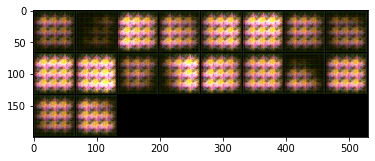

100%|██████████| 103/103 [00:34<00:00,  2.98it/s]


epoch: 1, lossD:1.5221566609965944, lossG:3.182957172393799,lossG_fake:1.7782121352779054, lossG_real:1.4047450232274323 ,equality:0.3734671120504731


evaluate:117.7734146118164,kid_mean:0.06682078540325165, kid_std:0.04869944602251053,kid_:(tensor(0.0668), tensor(0.0487))


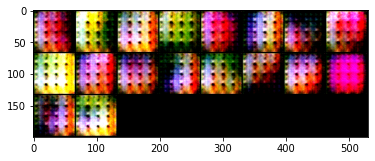

100%|██████████| 103/103 [00:35<00:00,  2.91it/s]


epoch: 2, lossD:1.6637764358983456, lossG:2.6587577884637037,lossG_fake:1.4480835303519537, lossG_real:1.210674266792038 ,equality:0.23740926355991565


evaluate:104.02130126953125,kid_mean:0.05522308498620987, kid_std:0.05419979616999626,kid_:(tensor(0.0552), tensor(0.0542))


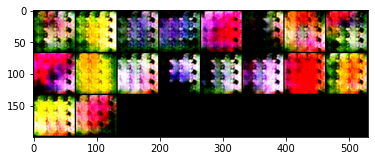

100%|██████████| 103/103 [00:36<00:00,  2.82it/s]


epoch: 3, lossD:1.7217500730625634, lossG:2.609228279984113,lossG_fake:1.4213412166799155, lossG_real:1.1878870615681398 ,equality:0.2334541551117757


evaluate:104.85045623779297,kid_mean:0.0585845485329628, kid_std:0.055907975882291794,kid_:(tensor(0.0586), tensor(0.0559))


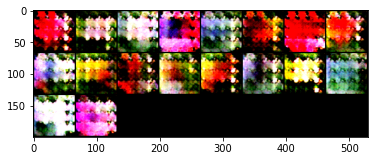

100%|██████████| 103/103 [00:35<00:00,  2.89it/s]


epoch: 4, lossD:1.790237807533116, lossG:2.493631601333618,lossG_fake:1.3390683682219495, lossG_real:1.1545632423706425 ,equality:0.18450512585130707


evaluate:110.342529296875,kid_mean:0.059526968747377396, kid_std:0.05769522115588188,kid_:(tensor(0.0595), tensor(0.0577))


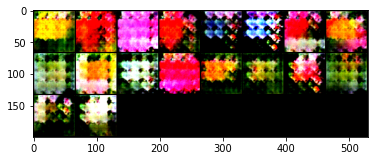

100%|██████████| 103/103 [00:36<00:00,  2.85it/s]


epoch: 5, lossD:1.7979305334461546, lossG:2.4673018386063066,lossG_fake:1.3194848646238013, lossG_real:1.14781698034805 ,equality:0.1716678842757513


evaluate:111.29029083251953,kid_mean:0.06515433639287949, kid_std:0.05657827481627464,kid_:(tensor(0.0652), tensor(0.0566))


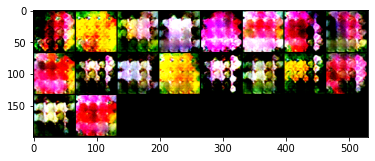

100%|██████████| 103/103 [00:36<00:00,  2.82it/s]


epoch: 6, lossD:1.808091361545822, lossG:2.477842828602467,lossG_fake:1.3158015568279526, lossG_real:1.1620412700384566 ,equality:0.15376028678949605


evaluate:113.26898193359375,kid_mean:0.07260754704475403, kid_std:0.06313066184520721,kid_:(tensor(0.0726), tensor(0.0631))


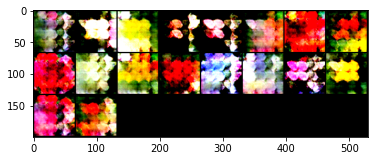

100%|██████████| 103/103 [00:35<00:00,  2.88it/s]


epoch: 7, lossD:1.8051702073476847, lossG:2.4535982793974647,lossG_fake:1.2883728071323877, lossG_real:1.165225476315878 ,equality:0.12314733081650964


evaluate:108.53963470458984,kid_mean:0.06569797545671463, kid_std:0.07231155782938004,kid_:(tensor(0.0657), tensor(0.0723))


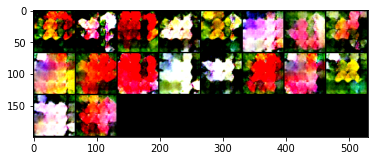

100%|██████████| 103/103 [00:35<00:00,  2.88it/s]


epoch: 8, lossD:1.8796550116492707, lossG:2.405114766463493,lossG_fake:1.274442430260112, lossG_real:1.130672330416522 ,equality:0.14377009984359002


evaluate:110.1263656616211,kid_mean:0.05218429118394852, kid_std:0.04869725555181503,kid_:(tensor(0.0522), tensor(0.0487))


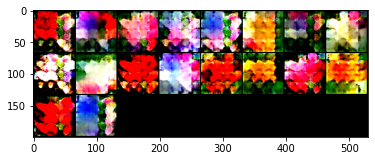

100%|██████████| 103/103 [00:36<00:00,  2.80it/s]


epoch: 9, lossD:1.8257404716269483, lossG:2.4011493562494666,lossG_fake:1.2603978479950173, lossG_real:1.1407515134626223 ,equality:0.11964633453239504


evaluate:110.15460968017578,kid_mean:0.05658024922013283, kid_std:0.054964423179626465,kid_:(tensor(0.0566), tensor(0.0550))


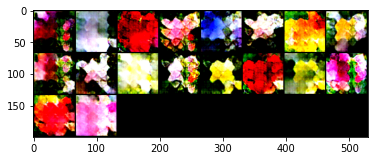

100%|██████████| 103/103 [00:35<00:00,  2.89it/s]


epoch: 10, lossD:1.826172384243567, lossG:2.3869391714484944,lossG_fake:1.2538964146549263, lossG_real:1.1330427504280238 ,equality:0.12085366422690247


evaluate:107.64501953125,kid_mean:0.07093193382024765, kid_std:0.06699226051568985,kid_:(tensor(0.0709), tensor(0.0670))


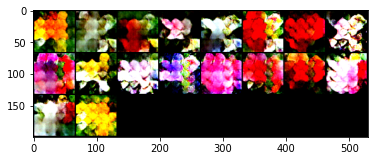

100%|██████████| 103/103 [00:35<00:00,  2.87it/s]


epoch: 11, lossD:1.8452043232408541, lossG:2.4053389539996397,lossG_fake:1.2488132547406317, lossG_real:1.1565256871066047 ,equality:0.0922875676340269


evaluate:108.62162017822266,kid_mean:0.05157792568206787, kid_std:0.04424559697508812,kid_:(tensor(0.0516), tensor(0.0442))


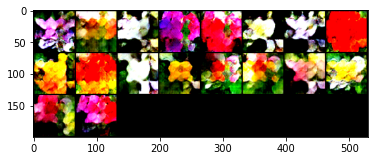

100%|██████████| 103/103 [00:35<00:00,  2.88it/s]


epoch: 12, lossD:1.8228365773136177, lossG:2.3781699185232514,lossG_fake:1.245188079991387, lossG_real:1.1329818431613514 ,equality:0.11220623683003561


evaluate:113.74724578857422,kid_mean:0.06875637918710709, kid_std:0.062141720205545425,kid_:(tensor(0.0688), tensor(0.0621))


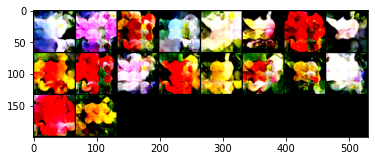

100%|██████████| 103/103 [00:36<00:00,  2.86it/s]


epoch: 13, lossD:1.8723569078352844, lossG:2.3700708208732233,lossG_fake:1.2285022041172657, lossG_real:1.1415686040248685 ,equality:0.08693360009239726


evaluate:115.61825561523438,kid_mean:0.07513809204101562, kid_std:0.07276654243469238,kid_:(tensor(0.0751), tensor(0.0728))


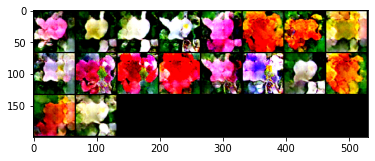

100%|██████████| 103/103 [00:36<00:00,  2.80it/s]


epoch: 14, lossD:2.001524905556614, lossG:2.3836458840416475,lossG_fake:1.2531424564065285, lossG_real:1.1305034293711764 ,equality:0.12263902703535212


evaluate:115.6801986694336,kid_mean:0.08172955363988876, kid_std:0.07341719418764114,kid_:(tensor(0.0817), tensor(0.0734))


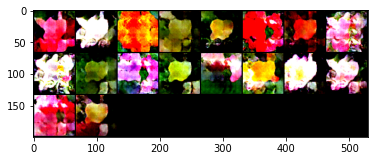

100%|██████████| 103/103 [00:35<00:00,  2.88it/s]


epoch: 15, lossD:1.8653117499305207, lossG:2.250664548966491,lossG_fake:1.1499187176667371, lossG_real:1.1007458422947856 ,equality:0.049172875371951585


evaluate:115.0746078491211,kid_mean:0.07495797425508499, kid_std:0.06341675668954849,kid_:(tensor(0.0750), tensor(0.0634))


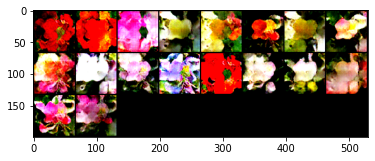

100%|██████████| 103/103 [00:35<00:00,  2.87it/s]


epoch: 16, lossD:1.8449312633681065, lossG:2.329322546431162,lossG_fake:1.20220221593542, lossG_real:1.12712032933837 ,equality:0.07508188659704995


evaluate:117.7986068725586,kid_mean:0.07558056712150574, kid_std:0.0654565766453743,kid_:(tensor(0.0756), tensor(0.0655))


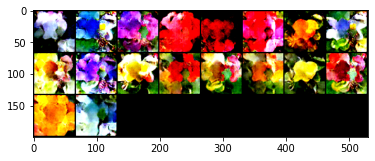

100%|██████████| 103/103 [00:36<00:00,  2.79it/s]


epoch: 17, lossD:1.9249320296407904, lossG:2.387780673295549,lossG_fake:1.2436295938723296, lossG_real:1.1441510788445335 ,equality:0.09947851502779614


evaluate:117.69233703613281,kid_mean:0.07095496356487274, kid_std:0.05994205176830292,kid_:(tensor(0.0710), tensor(0.0599))


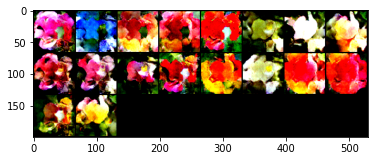

100%|██████████| 103/103 [00:36<00:00,  2.84it/s]


epoch: 18, lossD:1.8679025612988518, lossG:2.242883427629193,lossG_fake:1.1639680515215234, lossG_real:1.0789153772650413 ,equality:0.08505267425648211


evaluate:117.1303482055664,kid_mean:0.08594207465648651, kid_std:0.06878532469272614,kid_:(tensor(0.0859), tensor(0.0688))


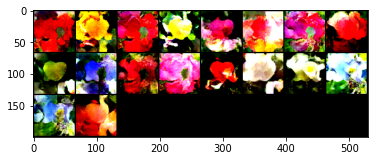

100%|██████████| 103/103 [00:36<00:00,  2.84it/s]


epoch: 19, lossD:1.8658726562574073, lossG:2.3185181478852206,lossG_fake:1.1944399499198766, lossG_real:1.1240782101177476 ,equality:0.07036173980212901


evaluate:116.91754913330078,kid_mean:0.0750599130988121, kid_std:0.06238354369997978,kid_:(tensor(0.0751), tensor(0.0624))


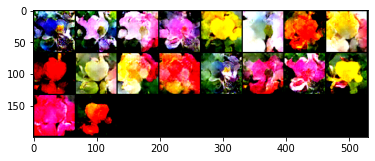

100%|██████████| 103/103 [00:37<00:00,  2.76it/s]


epoch: 20, lossD:1.9447977785925263, lossG:2.356409234908021,lossG_fake:1.2286203601985302, lossG_real:1.1277888793389774 ,equality:0.10083148085955274


evaluate:114.76765441894531,kid_mean:0.07694216072559357, kid_std:0.06511623412370682,kid_:(tensor(0.0769), tensor(0.0651))


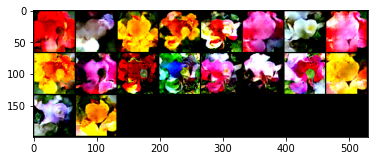

100%|██████████| 103/103 [00:36<00:00,  2.84it/s]


epoch: 21, lossD:1.8524106694656668, lossG:2.2784465539802627,lossG_fake:1.1670872673247625, lossG_real:1.1113592901276153 ,equality:0.05572797719714728


evaluate:113.2139663696289,kid_mean:0.07043610513210297, kid_std:0.0606495663523674,kid_:(tensor(0.0704), tensor(0.0606))


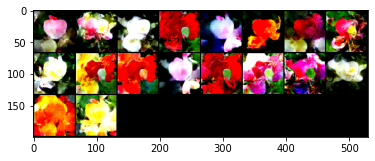

100%|██████████| 103/103 [00:36<00:00,  2.82it/s]


epoch: 22, lossD:1.8755383537810983, lossG:2.376189072155258,lossG_fake:1.2185985602221443, lossG_real:1.1575905130904856 ,equality:0.06100804713165875


evaluate:112.49859619140625,kid_mean:0.06950956583023071, kid_std:0.057201188057661057,kid_:(tensor(0.0695), tensor(0.0572))


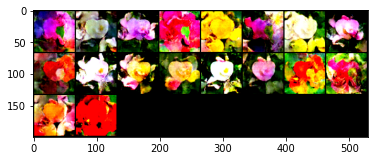

100%|██████████| 103/103 [00:36<00:00,  2.84it/s]


epoch: 23, lossD:1.8675321977115371, lossG:2.2909758715953643,lossG_fake:1.2087208009460597, lossG_real:1.0822550654411316 ,equality:0.12646573550492812


evaluate:112.31074523925781,kid_mean:0.06659848242998123, kid_std:0.06320545077323914,kid_:(tensor(0.0666), tensor(0.0632))


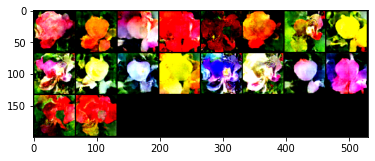

100%|██████████| 103/103 [00:36<00:00,  2.85it/s]


epoch: 24, lossD:1.8423651491554038, lossG:2.3771825045057873,lossG_fake:1.2319247051350122, lossG_real:1.1452577970560314 ,equality:0.08666690807898081


evaluate:113.91753387451172,kid_mean:0.06562578678131104, kid_std:0.05814118683338165,kid_:(tensor(0.0656), tensor(0.0581))


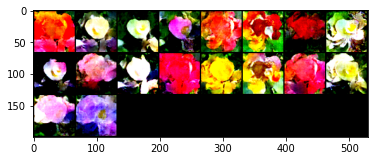

100%|██████████| 103/103 [00:36<00:00,  2.84it/s]


epoch: 25, lossD:1.8427708692921019, lossG:2.3770362914187237,lossG_fake:1.2488208146928583, lossG_real:1.1282154801979805 ,equality:0.12060533449487787


evaluate:112.84134674072266,kid_mean:0.07262613624334335, kid_std:0.06347217410802841,kid_:(tensor(0.0726), tensor(0.0635))


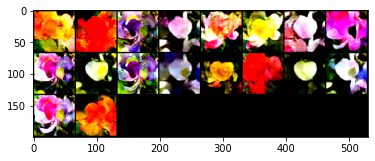

100%|██████████| 103/103 [00:36<00:00,  2.84it/s]


epoch: 26, lossD:1.8343049449828064, lossG:2.4005410949003347,lossG_fake:1.2424788689150394, lossG_real:1.1580622364016413 ,equality:0.08441663251339815


evaluate:111.64700317382812,kid_mean:0.07334738224744797, kid_std:0.07345593720674515,kid_:(tensor(0.0733), tensor(0.0735))


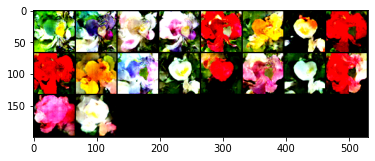

100%|██████████| 103/103 [00:36<00:00,  2.84it/s]


epoch: 27, lossD:1.9384335591955093, lossG:2.399872939563492,lossG_fake:1.2496793316405954, lossG_real:1.150193623547415 ,equality:0.09948570809318036


evaluate:111.6016616821289,kid_mean:0.06887076050043106, kid_std:0.06547145545482635,kid_:(tensor(0.0689), tensor(0.0655))


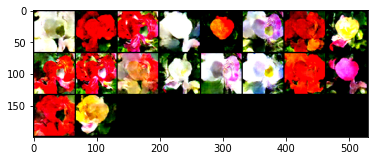

100%|██████████| 103/103 [00:37<00:00,  2.78it/s]


epoch: 28, lossD:1.815404187128382, lossG:2.371143459116371,lossG_fake:1.2165607665348979, lossG_real:1.154582696632274 ,equality:0.06197806990262378


evaluate:111.06459045410156,kid_mean:0.061226941645145416, kid_std:0.05653436481952667,kid_:(tensor(0.0612), tensor(0.0565))


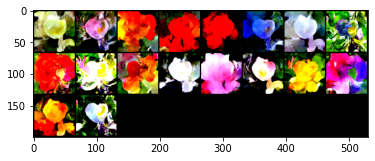

100%|██████████| 103/103 [00:36<00:00,  2.83it/s]


epoch: 29, lossD:1.8210120571469797, lossG:2.4155424937461185,lossG_fake:1.2528461408846587, lossG_real:1.1626963540188318 ,equality:0.09014978686582698


evaluate:110.4734878540039,kid_mean:0.06889986991882324, kid_std:0.059672437608242035,kid_:(tensor(0.0689), tensor(0.0597))


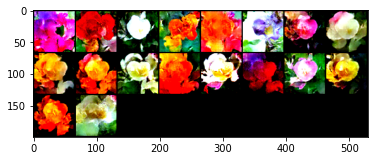

100%|██████████| 103/103 [00:36<00:00,  2.82it/s]


epoch: 30, lossD:1.8581670464821232, lossG:2.4342238486391827,lossG_fake:1.2465038531034895, lossG_real:1.1877199932209497 ,equality:0.05878385988253987


evaluate:110.94342041015625,kid_mean:0.06075603514909744, kid_std:0.058076322078704834,kid_:(tensor(0.0608), tensor(0.0581))


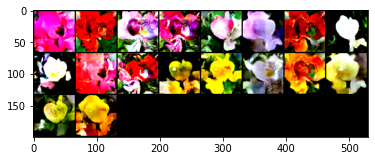

100%|██████████| 103/103 [00:37<00:00,  2.77it/s]


epoch: 31, lossD:1.7910226861250054, lossG:2.4436355053799823,lossG_fake:1.2525620495231407, lossG_real:1.1910734714813602 ,equality:0.06148857804178043


evaluate:110.45240783691406,kid_mean:0.06825879216194153, kid_std:0.05202203989028931,kid_:(tensor(0.0683), tensor(0.0520))


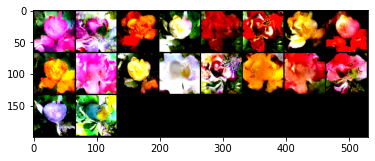

100%|██████████| 103/103 [00:36<00:00,  2.81it/s]


epoch: 32, lossD:1.9847445383812616, lossG:2.4287091412590547,lossG_fake:1.2457082769245778, lossG_real:1.1830008585476182 ,equality:0.06270741837695959


evaluate:111.4651870727539,kid_mean:0.06760944426059723, kid_std:0.05731173977255821,kid_:(tensor(0.0676), tensor(0.0573))


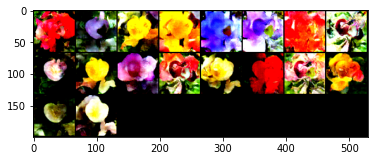

100%|██████████| 103/103 [00:36<00:00,  2.79it/s]


epoch: 33, lossD:1.782000973386672, lossG:2.4152582316722686,lossG_fake:1.2403154812970207, lossG_real:1.1749427376441586 ,equality:0.06537274365286216


evaluate:111.67390441894531,kid_mean:0.07624179124832153, kid_std:0.06127609312534332,kid_:(tensor(0.0762), tensor(0.0613))


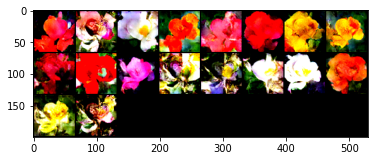

100%|██████████| 103/103 [00:37<00:00,  2.73it/s]


epoch: 34, lossD:1.8330997795734592, lossG:2.456836533777922,lossG_fake:1.2750370514045641, lossG_real:1.1817994684848971 ,equality:0.093237582919667


evaluate:112.567138671875,kid_mean:0.07485989481210709, kid_std:0.06884002685546875,kid_:(tensor(0.0749), tensor(0.0688))


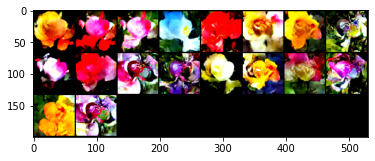

100%|██████████| 103/103 [00:36<00:00,  2.80it/s]


epoch: 35, lossD:1.801341541762491, lossG:2.4881712580190123,lossG_fake:1.2960938406222076, lossG_real:1.192077424341035 ,equality:0.10401641628117253


evaluate:112.890625,kid_mean:0.06797095388174057, kid_std:0.07023798674345016,kid_:(tensor(0.0680), tensor(0.0702))


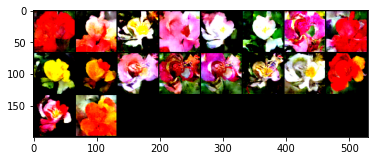

100%|██████████| 103/103 [00:36<00:00,  2.82it/s]


epoch: 36, lossD:1.768574811879871, lossG:2.5058638656023637,lossG_fake:1.2979609705869435, lossG_real:1.2079028799695877 ,equality:0.09005809061735581


evaluate:113.15861511230469,kid_mean:0.06998749822378159, kid_std:0.056851036846637726,kid_:(tensor(0.0700), tensor(0.0569))


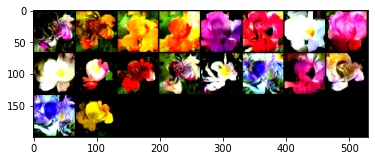

100%|██████████| 103/103 [00:37<00:00,  2.73it/s]


epoch: 37, lossD:1.861832852502471, lossG:2.4999509529002664,lossG_fake:1.292515880853227, lossG_real:1.2074350847781283 ,equality:0.08508079607509877


evaluate:113.13086700439453,kid_mean:0.06845726817846298, kid_std:0.06604287028312683,kid_:(tensor(0.0685), tensor(0.0660))


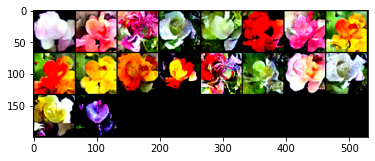

100%|██████████| 103/103 [00:36<00:00,  2.80it/s]


epoch: 38, lossD:1.764531851972191, lossG:2.5436538168527547,lossG_fake:1.3158547467398412, lossG_real:1.2277990562244527 ,equality:0.08805569051538842


evaluate:113.70086669921875,kid_mean:0.07334122061729431, kid_std:0.06333893537521362,kid_:(tensor(0.0733), tensor(0.0633))


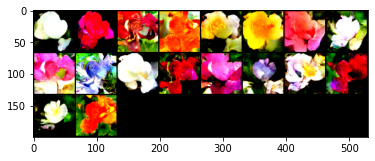

100%|██████████| 103/103 [00:36<00:00,  2.82it/s]


epoch: 39, lossD:1.7454104157327448, lossG:2.5677508011604977,lossG_fake:1.3263325552338536, lossG_real:1.2414182679167072 ,equality:0.08491428731714645


evaluate:112.8813705444336,kid_mean:0.07142893224954605, kid_std:0.06498752534389496,kid_:(tensor(0.0714), tensor(0.0650))


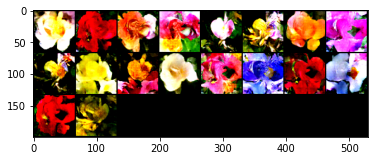

100%|██████████| 103/103 [00:36<00:00,  2.82it/s]


epoch: 40, lossD:1.7543869759272603, lossG:2.6035845140808993,lossG_fake:1.3462406524176735, lossG_real:1.2573438616632258 ,equality:0.08889679075444779


evaluate:111.8370361328125,kid_mean:0.06392934173345566, kid_std:0.05446493625640869,kid_:(tensor(0.0639), tensor(0.0545))


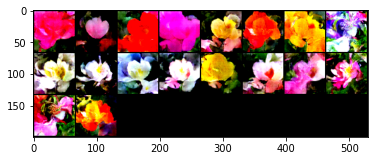

100%|██████████| 103/103 [00:36<00:00,  2.81it/s]


epoch: 41, lossD:1.7216845137401693, lossG:2.6022507056449222,lossG_fake:1.3314994330545074, lossG_real:1.2707512639101268 ,equality:0.060748169144380526


evaluate:112.36559295654297,kid_mean:0.07092731446027756, kid_std:0.06708289682865143,kid_:(tensor(0.0709), tensor(0.0671))


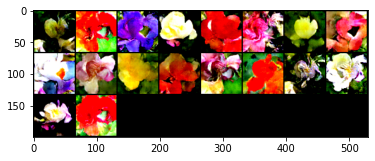

100%|██████████| 103/103 [00:36<00:00,  2.81it/s]


epoch: 42, lossD:1.830749195756264, lossG:2.5892807534597453,lossG_fake:1.333490879211611, lossG_real:1.255789862095731 ,equality:0.07770101711587984


evaluate:111.25885009765625,kid_mean:0.06569599360227585, kid_std:0.0594838410615921,kid_:(tensor(0.0657), tensor(0.0595))


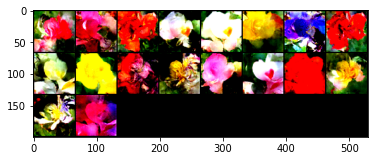

100%|██████████| 103/103 [00:36<00:00,  2.81it/s]


epoch: 43, lossD:1.7005407439852225, lossG:2.643960624065214,lossG_fake:1.3569089822398805, lossG_real:1.2870516539777366 ,equality:0.06985732826214397


evaluate:111.1913070678711,kid_mean:0.0741976797580719, kid_std:0.05960407853126526,kid_:(tensor(0.0742), tensor(0.0596))


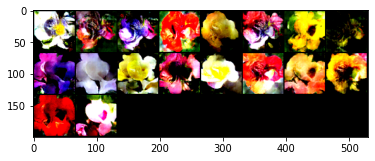

100%|██████████| 103/103 [00:36<00:00,  2.79it/s]


epoch: 44, lossD:1.6915513855739706, lossG:2.684134476393172,lossG_fake:1.3663012165467716, lossG_real:1.3178332552169134 ,equality:0.0484679613298582


evaluate:111.65740966796875,kid_mean:0.07573729753494263, kid_std:0.06962694227695465,kid_:(tensor(0.0757), tensor(0.0696))


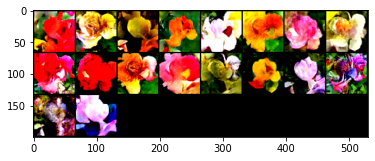

100%|██████████| 103/103 [00:37<00:00,  2.74it/s]


epoch: 45, lossD:1.7769496660788082, lossG:2.690334975140766,lossG_fake:1.3797741260343386, lossG_real:1.3105608525785428 ,equality:0.06921327345579575


evaluate:111.49769592285156,kid_mean:0.08502749353647232, kid_std:0.07090693712234497,kid_:(tensor(0.0850), tensor(0.0709))


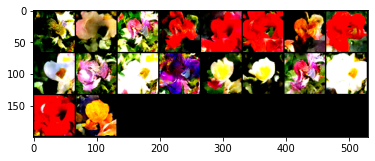

100%|██████████| 103/103 [00:36<00:00,  2.81it/s]


epoch: 46, lossD:1.6635283301177535, lossG:2.7106875840900013,lossG_fake:1.395281271448413, lossG_real:1.3154063068547295 ,equality:0.0798749645936836


evaluate:109.95832061767578,kid_mean:0.0729951560497284, kid_std:0.05489940568804741,kid_:(tensor(0.0730), tensor(0.0549))


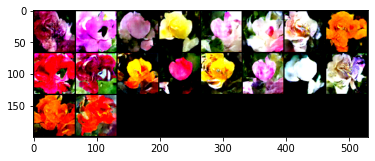

100%|██████████| 103/103 [00:36<00:00,  2.80it/s]


epoch: 47, lossD:1.6505034571712456, lossG:2.739056314079507,lossG_fake:1.4020159724846626, lossG_real:1.3370403525898757 ,equality:0.06497561989478684


evaluate:110.57079315185547,kid_mean:0.059926606714725494, kid_std:0.053258851170539856,kid_:(tensor(0.0599), tensor(0.0533))


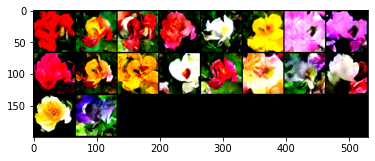

100%|██████████| 103/103 [00:37<00:00,  2.74it/s]


epoch: 48, lossD:1.6742805045785256, lossG:2.78421129069282,lossG_fake:1.4157428787749948, lossG_real:1.368468409603082 ,equality:0.047274469171912914


evaluate:110.5881118774414,kid_mean:0.07331831008195877, kid_std:0.0705924853682518,kid_:(tensor(0.0733), tensor(0.0706))


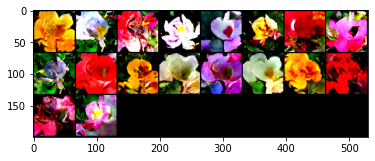

100%|██████████| 103/103 [00:36<00:00,  2.80it/s]


epoch: 49, lossD:1.6307169337874476, lossG:2.797943483278589,lossG_fake:1.4210271951064324, lossG_real:1.3769162852787278 ,equality:0.0441109098277046


evaluate:111.1937255859375,kid_mean:0.06526898592710495, kid_std:0.05660802125930786,kid_:(tensor(0.0653), tensor(0.0566))


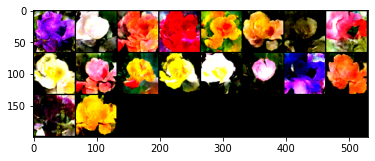

In [44]:
lossesD = []
lossesG = []

raw_lossesD = []
raw_lossesG = []
lossesG_fake = []
lossesG_real = []

equality = 0.0
sum_equality = 0.0
d_equality = []

relu = torch.nn.ReLU()

fid_ = []
kid_mean_ = []
kid_std_ = []
kid_score = []
for epoch in range(opt.n_epoch):
    running_lossD = 0.0 #損失関数初期化
    running_lossG = 0.0
    lossG_fake_running = 0.0
    lossG_real_running = 0.0

    #sum_equality += equality 
    equality = 0.0
   # for i , (real_imgs, _) in enumerate(tqdm.tqdm(dataloader, position = 0)):#celebA
    for i , real_imgs in enumerate(tqdm.tqdm(dataloader, position = 0)):#flower
        real_imgs = real_imgs.to(device)
        batch_size = real_imgs.size()[0]
        noise = torch.randn(batch_size, opt.z_dim, 1, 1).to(device)

        #train discriminator

        netD.zero_grad()
        output_real = netD(real_imgs)

        #lossD_real = criterion(output, labels_real)
        lossD_real = torch.mean(relu(1.0 - output_real))


        fake_imgs = netG(noise)##not train  output_fake_d
        output_fake_d = netD(fake_imgs.detach())#not train  output_fake_d

        #lossD_fake = criterion(output, labels_fake)
        lossD_fake = torch.mean(relu(1.0 + output_fake_d))
        

        lossD = lossD_real + lossD_fake
        #lossD = torch.mean(torch.log(torch.sigmoid(output_real)))- torch.mean(torch.log(torch.sigmoid(output_fake_d)))  #not train  output_fake_d
        lossD.backward()
        optimizerD.step()
        
        #train generator
        
        netG.zero_grad()#勾配初期

        output_fake_g = netD(fake_imgs)#train  output_fake_g
        output_real = netD(real_imgs)

        lossG_fake = torch.mean(relu(1.0 - output_fake_g))
        lossG_real = torch.mean(relu(1.0 + output_real))
        #lossG =  torch.mean(torch.log(torch.sigmoid(output_fake_g - output_real))) #- torch.mean(torch.log(torch.sigmoid(output_real)))#train  output_fake_g
        lossG =    lossG_real + lossG_fake    


        lossG.backward()
        optimizerG.step()
        
        # save loss
        
        running_lossD += lossD.item()
        running_lossG += lossG.item()
        
        raw_lossesD.append(lossD.item())
        raw_lossesG.append(lossG.item())

        lossG_fake_running += lossG_fake.item()
        lossG_real_running += lossG_real.item()


        
    running_lossD /=len(dataloader)
    running_lossG /=len(dataloader)

    lossG_fake_running /= len(dataloader)
    lossG_real_running /= len(dataloader)
#equality
    equality = ( lossG_fake_running - lossG_real_running  )
    d_equality.append(equality)


    print("epoch: {}, lossD:{}, lossG:{},lossG_fake:{}, lossG_real:{} ,equality:{}".format(epoch, running_lossD, running_lossG,lossG_fake_running,lossG_real_running,equality))#-->,lossG_fake:{}, lossG_real:{},lossG_fake_running,lossG_real_running
    lossesD.append(running_lossD)
    lossesG.append(running_lossG)

    lossesG_fake.append(lossG_fake_running)
    lossesG_real.append(lossG_real_running)

     #evaluate GAN
    fake_imgs_1 = fake_imgs.detach()
    real_imgs_1 = real_imgs.to(dtype=torch.uint8).cpu()
    fake_imgs_1 = fake_imgs_1.to(dtype=torch.uint8).cpu()
    fid.update(real_imgs_1, real=True)
    fid.update(fake_imgs_1, real=False)
    eval = fid.compute()

    kid.update(real_imgs_1, real=True)
    kid.update(fake_imgs_1, real=False)
    kid_ = kid.compute()
    kid_mean, kid_std = kid.compute()

    
  
    print("evaluate:{},kid_mean:{}, kid_std:{},kid_:{}".format(eval, kid_mean, kid_std, kid_))
    fid_.append(eval)
    kid_mean_.append(kid_mean)
    kid_std_.append(kid_std)
    kid_score.append(kid_)
    #show fake image
    grid_imgs = vutils.make_grid(fake_imgs[:24].detach()+0.5)
    grid_imgs_arr = grid_imgs.cpu().numpy()
    plt.imshow(np.transpose(grid_imgs_arr, (1,2,0)))
    plt.show()

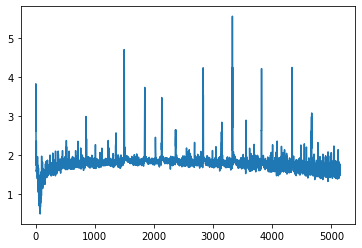

In [45]:
plt.plot(raw_lossesD)

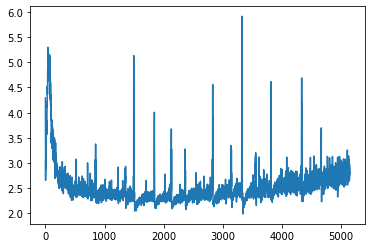

In [46]:
plt.plot(raw_lossesG)

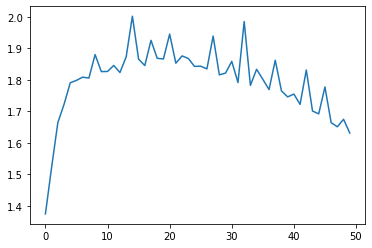

In [47]:
plt.plot(lossesD)

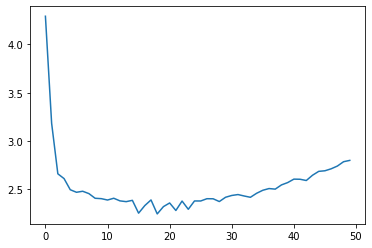

In [48]:
plt.plot(lossesG)

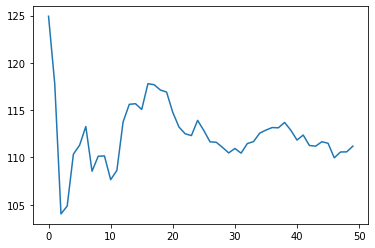

In [49]:
plt.plot(fid_)

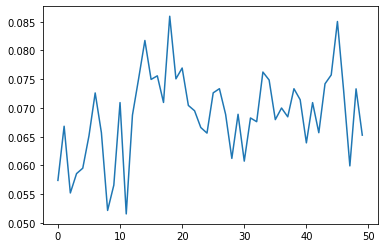

In [50]:
plt.plot(kid_mean_)

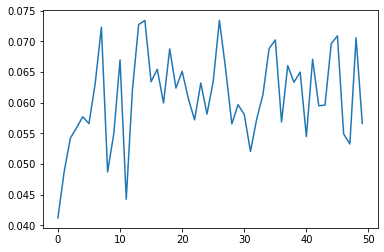

In [51]:
plt.plot(kid_std_)

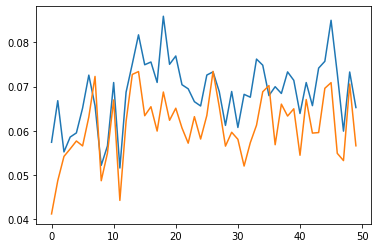

In [52]:
plt.plot(kid_score)

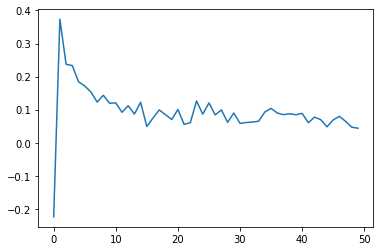

In [53]:
plt.plot(d_equality)

In [54]:

real_imgs = real_imgs.to(dtype=torch.uint8).cpu()
fake_imgs = fake_imgs.to(dtype=torch.uint8).cpu()
fid.update(real_imgs, real=True)
fid.update(fake_imgs, real=False)
fid.compute()

kid.update(real_imgs, real=True)
kid.update(fake_imgs, real=False)
kid.compute()

(tensor(0.0730), tensor(0.0658))